In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/Shared drives/SI671


In [ ]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import re
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

from sklearn.model_selection import train_test_split

In [ ]:
#from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
english_stemmer = nltk.stem.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read data from JSON file

In [ ]:
data = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

In [ ]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [ ]:
data.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [ ]:
# drop columns
drop_columns = ["reviewTime", "reviewerName", "unixReviewTime", "style","image",
                "verified", "vote"]
data = data.drop(drop_columns,axis=1)

In [ ]:
data.head()

,overall,reviewerID,asin,reviewText,summary
0,5,A1QVBUH9E1V6I8,4639725183,No adverse comment.,Five Stars
1,5,A3GEOILWLK86XM,4639725183,Gift for college student.,Great product.
2,5,A32RD6L701BIGP,4639725183,"If you like strong tea, this is for you. It mi...",Strong
3,5,A2UY1O1FBGKIE6,4639725183,Love the tea. The flavor is way better than th...,Great tea
4,5,A3QHVBQYDV7Z6U,4639725183,I have searched everywhere until I browsed Ama...,This is the tea I remembered!


In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
reviewText,reviewText,0.034095
summary,summary,0.019146
overall,overall,0.000000
reviewerID,reviewerID,0.000000
asin,asin,0.000000


In [ ]:
# drop rows that have missing values on reviewtext and summary
data = data.dropna(subset=['reviewText', 'summary'])

In [ ]:
# check the percentage again
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
overall,overall,0.0
reviewerID,reviewerID,0.0
asin,asin,0.0
reviewText,reviewText,0.0
summary,summary,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


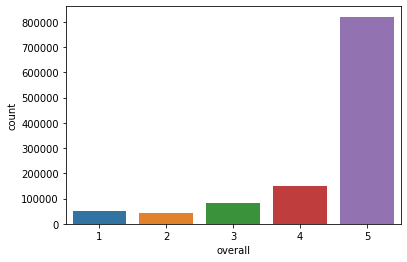

In [ ]:
# Get the distribution of overall grades
sbn.countplot(data["overall"])
plt.show()

In [ ]:
def data_preprocessing(rev, remove_stopwords=True):
  new_text = re.sub("[^a-zA-Z]", " ", rev)
  words = new_text.lower().split()

  if remove_stopwords:
    sts = set(stop)
    words = [w for w in words if w not in sts]
  ary = []
  for word in words:
    ary.append(english_stemmer.stem(word))
  return ary

In [ ]:
clean_reviewData = []
for rev in data["reviewText"]:
  clean_reviewData.append(" ".join(data_preprocessing(rev)))

clean_summaryData = []
for rev in data["summary"]:
  clean_summaryData.append(" ".join(data_preprocessing(rev)))

In [ ]:
Most_Used_Words_Review = pd.Series(" ".join(clean_reviewData).lower().split()).value_counts()[:20]
print(Most_Used_Words_Review) 

tast       371477
good       343089
like       319488
great      294147
flavor     292500
love       251100
use        237476
product    193775
tea        180443
one        177377
coffe      172902
make       150900
tri        145373
buy        123550
get        123260
price      114944
realli     112873
would      105434
time       105147
much        99182
dtype: int64


In [ ]:
Most_Used_Words_Summary = pd.Series(" ".join(clean_summaryData).lower().split()).value_counts()[:20]
print(Most_Used_Words_Summary) 

star       300468
five       232052
great      125580
good       116901
tast        69455
love        59949
flavor      43427
best        38554
four        36212
like        36066
product     35272
delici      32352
tea         31979
coffe       31468
tasti       21773
price       21093
yummi       19836
excel       19329
one         18891
favorit     17562
dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)
test_vecor = text_vectorizer.fit_transform(clean_reviewData)
tfidf_vector = dict(zip(text_vectorizer.get_feature_names(), text_vectorizer.idf_))

In [ ]:
tfidf_vector

{'abl': 5.464486048004527,
 'absolut': 5.19304456538592,
 'acid': 6.012204802028105,
 'actual': 4.853498809812661,
 'ad': 4.562614889703907,
 'add': 4.13066548902756,
 'addict': 5.582164605836234,
 'addit': 5.40697730715395,
 'advertis': 6.318722820674004,
 'afford': 6.68017873170078,
 'afternoon': 6.4510052167939325,
 'aftertast': 5.785545755317994,
 'ago': 5.817585109062611,
 'agre': 6.781220322647784,
 'air': 6.684802423472621,
 'allergi': 6.688413466860008,
 'allow': 6.40403140710892,
 'almond': 5.197340154506941,
 'almost': 4.985216965313002,
 'alon': 6.601832845853779,
 'along': 5.990111635711399,
 'alreadi': 5.8807616592395915,
 'also': 3.8185198442953054,
 'altern': 5.572721343692428,
 'although': 5.608405557266037,
 'alway': 4.337161263902064,
 'amaz': 5.088895394787844,
 'amazon': 4.10590891079697,
 'american': 6.807651048227386,
 'amount': 4.844015785485125,
 'anoth': 4.9629281613641,
 'anymor': 6.5134401168931415,
 'anyon': 5.762658617436359,
 'anyth': 5.070279623737226,
 '

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyser = SentimentIntensityAnalyzer()
sample_review = data.reviewText[:10]
for test in sample_review:
  print(test)
  ss = analyser.polarity_scores(test)
  for k in sorted(ss):
    print("{}:{}".format(k, ss[k]))
  print("===============================")

No adverse comment.
compound:-0.5719
neg:0.825
neu:0.175
pos:0.0
Gift for college student.
compound:0.4404
neg:0.0
neu:0.508
pos:0.492
If you like strong tea, this is for you. It might even be a little too strong for me.
compound:0.8442
neg:0.0
neu:0.622
pos:0.378
Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.
compound:0.8402
neg:0.0
neu:0.625
pos:0.375
I have searched everywhere until I browsed Amazon and found it!  This is the tea Lipton should be selling on grocery store shelves.  The stuff I last purchased is just awful, and nowhere near as good as I remember.
compound:-0.6121
neg:0.145
neu:0.812
pos:0.043
Tea made with Lipton Yellow Label teabags is much better than tea made with regular Lipton teabags.
compound:0.4404
neg:0.0
neu:0.847
pos:0.153
I love this tea!  Okay, I'm not a high falutin' tea snob, but I first enjoyed this Lipton yellow label tea when on a trip to Singapore, and whether it was the room service, the company

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# cluster review data
clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init="k-means++", 
                               n_init=1, init_size=1000, batch_size=1000, 
                               verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vecor)
kmodel_clusters = kmodel.predict(test_vecor)
kmodel_distances = kmodel.transform(test_vecor)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names()
for i in range(clusters):
  print("Cluster %d:" % i)
  for j in centroids[i, :5]:
    print("%s" % values[j])
  print()

Cluster 0:
delici
fresh
love
great
absolut

Cluster 1:
coffe
good
flavor
cup
great

Cluster 2:
yummi
love
great
good
fresh

Cluster 3:
thank
great
product
good
love

Cluster 4:
great
product
tast
price
flavor

Cluster 5:
tea
love
tast
flavor
green

Cluster 6:
side
small
bit
bitter
expens

Cluster 7:
order
system
hook
plastic
next

Cluster 8:
tell
short
appreci
effect
process

Cluster 9:
coffe
reduc
acid
pleasant
spice

Cluster 10:
love
kid
product
flavor
tast

Cluster 11:
drop
potato
believ
three
month

Cluster 12:
excel
product
qualiti
tast
price

Cluster 13:
dress
get
style
tart
slice

Cluster 14:
good
tast
like
flavor
use

Cluster 15:
nice
flavor
tast
good
great

Cluster 16:
raspberri
smell
licoric
tini
hint

Cluster 17:
stuff
good
love
great
use

Cluster 18:
chip
bag
potato
case
like

Cluster 19:
loos
blood
dinner
weight
lower



In [ ]:
test_reviewText = data.reviewText
test_Ratings = data.overall
text_vectorizer = TfidfVectorizer(max_df = 0.8)
text_vectorizer.fit(test_reviewText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
def rate(r):
  ary2 = []
  for rating in r:
    tv = [0]*5
    tv[rating-1] = 1
    ary2.append(tv)
  return np.array(ary2)

In [ ]:
test_reviewText = test_reviewText[:2000]
test_reviewText

0                                     No adverse comment.
1                               Gift for college student.
2       If you like strong tea, this is for you. It mi...
3       Love the tea. The flavor is way better than th...
4       I have searched everywhere until I browsed Ama...
                              ...                        
1996    Not that great. Certainly not worth the cost. ...
1997    Excellent Cookies.  We ate them very quickly a...
1998    The recipients were very pleased with these co...
1999             Grandson loved them ....he's at school .
2000                                   Addictive cookies!
Name: reviewText, Length: 2000, dtype: object

In [ ]:
test_ratings = test_Ratings[:2000]
test_Ratings

0          5
1          5
2          5
3          5
4          5
          ..
1143855    5
1143856    5
1143857    5
1143858    5
1143859    3
Name: overall, Length: 1143292, dtype: int64

In [ ]:
x = text_vectorizer.transform(test_reviewText).toarray()
y = rate(test_ratings.values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1]))
model.add(Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32,verbose=1)

Epoch 1/10
50/50 [==============================] - 8s 164ms/step - loss: 1.1033 - accuracy: 0.7075 - val_loss: 0.9572 - val_accuracy: 0.7200
Epoch 2/10
50/50 [==============================] - 8s 155ms/step - loss: 0.8287 - accuracy: 0.7181 - val_loss: 0.8793 - val_accuracy: 0.7200
Epoch 3/10
50/50 [==============================] - 8s 155ms/step - loss: 0.6930 - accuracy: 0.7275 - val_loss: 0.8366 - val_accuracy: 0.7250
Epoch 4/10
50/50 [==============================] - 8s 157ms/step - loss: 0.5787 - accuracy: 0.7706 - val_loss: 0.8234 - val_accuracy: 0.7275
Epoch 5/10
50/50 [==============================] - 8s 159ms/step - loss: 0.4831 - accuracy: 0.8319 - val_loss: 0.8399 - val_accuracy: 0.7300
Epoch 6/10
50/50 [==============================] - 8s 155ms/step - loss: 0.4031 - accuracy: 0.8844 - val_loss: 0.8582 - val_accuracy: 0.7200
Epoch 7/10
50/50 [==============================] - 8s 154ms/step - loss: 0.3343 - accuracy: 0.9200 - val_loss: 0.8893 - val_accuracy: 0.7250
Epoch 

In [ ]:
model.evaluate(x_test,y_test)

13/13 [==============================] - 0s 22ms/step - loss: 1.0381 - accuracy: 0.7200


[1.0381364822387695, 0.7200000286102295]